In [1]:
# %% cell — install transformers only
!pip install transformers --quiet


In [2]:
import torch, torchvision, transformers, sklearn, wordcloud


In [3]:





import os
import torch
import numpy as np
import random

class CFG:
    seed        = 42
    img_size    = 224
    batch_size  = 32
    epochs      = 5
    lr_text     = 2e-5   # lower for BERT
    lr_image    = 1e-4   # ResNet

    max_len     = 64
    pos_weight  = 1.0
    device      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    data_dir    = '/kaggle/input/meme-dataset/data'
    img_dir     = f"{data_dir}/img"
    train_json  = f"{data_dir}/train.jsonl"
    val_json    = f"{data_dir}/dev.jsonl"
    test_json   = f"{data_dir}/test.jsonl"

    log_dir     = './logs'





# Set seed
torch.manual_seed(CFG.seed)
np.random.seed(CFG.seed)
random.seed(CFG.seed)


In [4]:







from torchvision import transforms
from transformers import AutoTokenizer

img_transforms = {
    'train': transforms.Compose([
        transforms.Resize((CFG.img_size, CFG.img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize((CFG.img_size, CFG.img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ]),
}





tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [5]:
from torch.utils.data import Dataset
from PIL import Image
import json



class HatefulMemesDataset(Dataset):
    def __init__(self, jsonl_path, img_dir, tokenizer, transform, max_len):
        self.samples = [json.loads(l) for l in open(jsonl_path, 'r')]
        self.img_dir = img_dir
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_len = max_len

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]

        # Ensure filename works regardless of format
        img_name = os.path.basename(s['img'])
        img_path = os.path.join(self.img_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)

        enc = self.tokenizer(
            s['text'],
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'image': img,
            'input_ids': enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0),
            'label': torch.tensor(s['label'], dtype=torch.float) if 'label' in s else -1

        }


In [6]:
from torch.utils.data import DataLoader

train_ds = HatefulMemesDataset(CFG.train_json, CFG.img_dir, tokenizer, img_transforms['train'], CFG.max_len)
val_ds   = HatefulMemesDataset(CFG.val_json,   CFG.img_dir, tokenizer, img_transforms['val'],   CFG.max_len)
test_ds  = HatefulMemesDataset(CFG.test_json,  CFG.img_dir, tokenizer, img_transforms['val'],   CFG.max_len)

train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=CFG.batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=CFG.batch_size, shuffle=False, num_workers=2)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")


Train: 8500, Val: 500, Test: 1000


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


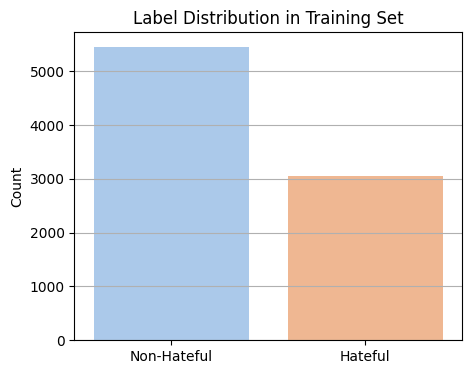

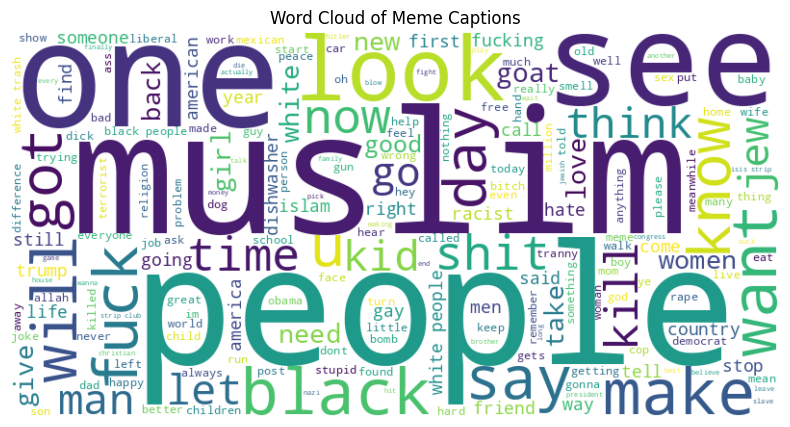

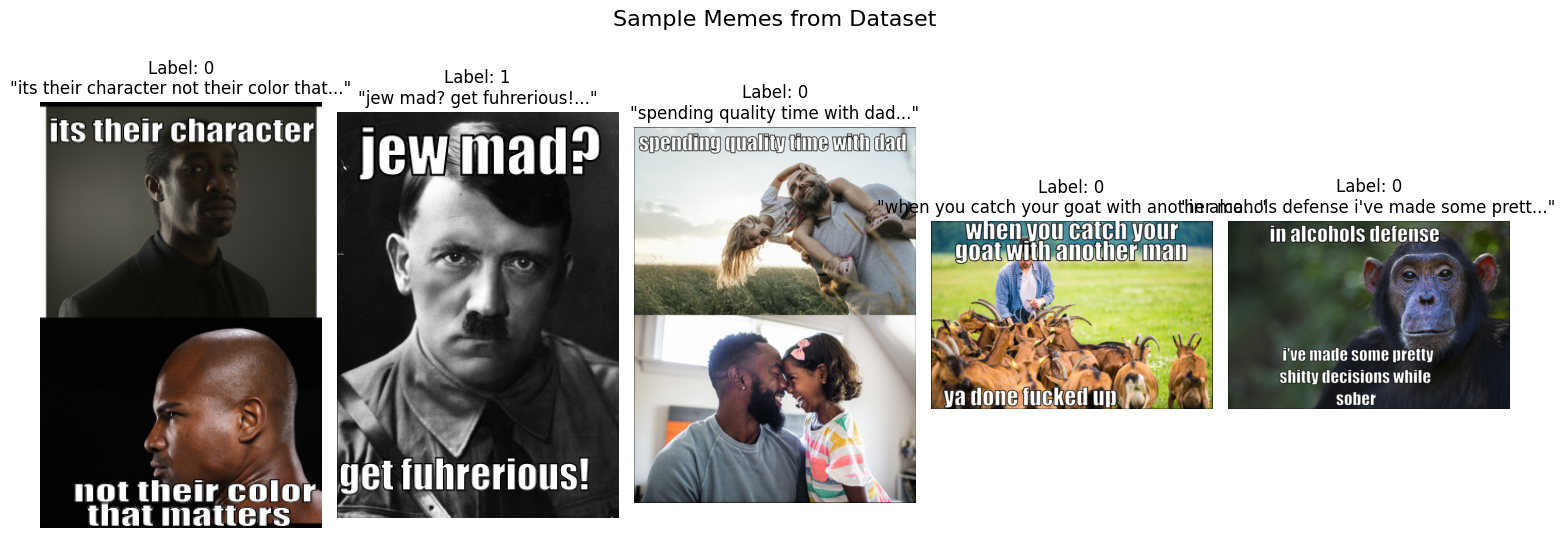

In [7]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import pandas as pd
from PIL import Image




# Load full train dataset
train_samples = [json.loads(l) for l in open(CFG.train_json, 'r')]




# ====== Class Distribution ======
labels = [s['label'] for s in train_samples]
plt.figure(figsize=(5,4))
sns.countplot(x=labels, palette='pastel')
plt.xticks([0,1], ["Non-Hateful", "Hateful"])
plt.title("Label Distribution in Training Set")
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()








# ====== Word Cloud ======
all_text = " ".join(s['text'] for s in train_samples)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Meme Captions")
plt.show()






# ====== Sample Memes ======
sample_ids = [0, 10, 100, 250, 500]
plt.figure(figsize=(15, 6))

for i, idx in enumerate(sample_ids):
    sample = train_samples[idx]
    img_path = os.path.join(CFG.img_dir, os.path.basename(sample['img']))
    img = Image.open(img_path)

    plt.subplot(1, len(sample_ids), i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Label: {sample['label']}\n\"{sample['text'][:40]}...\"")

plt.suptitle("Sample Memes from Dataset", fontsize=16)
plt.tight_layout()
plt.show()


In [8]:
# %% Cell 5 – Model Definitions

import torch.nn as nn
from transformers import BertForSequenceClassification
from torchvision import models

from transformers import BertModel

from transformers import BertModel, BertForSequenceClassification

# ✅ For Early Fusion (uses [CLS])
class TextModelFeature(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
    def forward(self, input_ids, attention_mask):
        return self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)

# ✅ For Late Fusion (returns logits directly)
class TextModelLogit(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    def forward(self, input_ids, attention_mask):
        return self.bert(input_ids=input_ids, attention_mask=attention_mask).logits.squeeze(-1)

class ImageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = models.resnet50(pretrained=True)
        self.base.fc = nn.Linear(self.base.fc.in_features, 1)
    def forward(self, x):
        return self.base(x).squeeze(-1)
        
class LateFusion(nn.Module):
    def __init__(self, text_model, image_model):
        super().__init__()
        self.text_model = text_model
        self.image_model = image_model
        self.fc = nn.Linear(2, 1)

    def forward(self, input_ids, attention_mask, image):
        t = self.text_model(input_ids, attention_mask)  # no sigmoid
        i = self.image_model(image)                     # no sigmoid
        x = torch.stack([t, i], dim=1)
        return self.fc(x).squeeze(-1)



class EarlyFusion(nn.Module):

    def __init__(self, text_model, image_model, text_dim=768, img_dim=2048, hidden_dim=512):
        super().__init__()
        self.text_model = text_model
        self.image_model = image_model
        self.dropout = nn.Dropout(0.5)  ## increased dropout


        # feature extractor, not classifiers
        self.text_fc = nn.Linear(text_dim, hidden_dim)
        self.img_fc  = nn.Linear(img_dim, hidden_dim)

        self.classifier = nn.Sequential(
        nn.Linear(hidden_dim * 2, 256),
        nn.ReLU(),
        nn.Dropout(0.5),     # add dropout
        nn.Linear(256, 1)
)


    def forward(self, input_ids, attention_mask, image):
        # Get BERT [CLS] feature (not final logit)
        text_outputs = self.text_model(input_ids, attention_mask)  # ✅ new
        text_feat = text_outputs.last_hidden_state[:, 0, :]        # [CLS]

        text_feat = text_outputs.last_hidden_state[:,0,:]  # [CLS]

        # Get ResNet penultimate feature
        x = self.image_model.base.conv1(image)
        x = self.image_model.base.bn1(x)
        x = self.image_model.base.relu(x)
        x = self.image_model.base.maxpool(x)
        x = self.image_model.base.layer1(x)
        x = self.image_model.base.layer2(x)
        x = self.image_model.base.layer3(x)
        x = self.image_model.base.layer4(x)
        x = self.image_model.base.avgpool(x)
        img_feat = torch.flatten(x, 1)  # shape: (B, 2048)

        # Project and fuse
        text_proj = self.dropout(self.text_fc(text_feat))
        img_proj  = self.dropout(self.img_fc(img_feat))
        fused     = torch.cat([text_proj, img_proj], dim=1)
        return self.classifier(fused).squeeze(-1)



2025-05-22 07:07:23.514961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747897643.701471      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747897643.755372      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
# Calculate pos_weight from training dataset
num_neg = sum(1 for s in train_ds.samples if s['label'] == 0)
num_pos = sum(1 for s in train_ds.samples if s['label'] == 1)
pos_weight_val = num_neg / num_pos

# Weighted BCE loss
pos_weight = torch.tensor([pos_weight_val]).to(CFG.device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

print(f"Using pos_weight = {pos_weight_val:.2f}")


Using pos_weight = 1.79


In [10]:
# trainingggggg

from sklearn.metrics import roc_auc_score
from torch.utils.tensorboard import SummaryWriter

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(CFG.pos_weight).to(CFG.device))
writer = SummaryWriter(CFG.log_dir)

def train_epoch(model, loader, optimizer, device, epoch):
    model.train()
    total_loss, preds, labels = 0, [], []
    for b in loader:
        image = b['image'].to(device)
        ids = b['input_ids'].to(device)
        mask = b['attention_mask'].to(device)
        y = b['label'].to(device)

        optimizer.zero_grad()
        out = model(ids, mask, image)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds += out.detach().cpu().tolist()
        labels += y.cpu().tolist()

    auc = roc_auc_score(labels, preds)
    writer.add_scalar("Train/Loss", total_loss/len(loader), epoch)
    writer.add_scalar("Train/AUC", auc, epoch)
    return total_loss/len(loader), auc



from sklearn.metrics import roc_auc_score, f1_score

def eval_epoch(model, loader, device, epoch):
    model.eval()
    total_loss, preds, labels = 0, [], []

    with torch.no_grad():
        for b in loader:
            image = b['image'].to(device)
            ids = b['input_ids'].to(device)
            mask = b['attention_mask'].to(device)
            y = b['label'].to(device)

            out = model(ids, mask, image)
            loss = criterion(out, y)

            total_loss += loss.item()
            preds += torch.sigmoid(out).cpu().tolist()
            labels += y.cpu().tolist()

    # Convert to binary predictions
    binary_preds = [1 if p > 0.5 else 0 for p in preds]

    auc = roc_auc_score(labels, preds)
    f1 = f1_score(labels, binary_preds)

    writer.add_scalar("Val/Loss", total_loss/len(loader), epoch)
    writer.add_scalar("Val/AUC", auc, epoch)
    writer.add_scalar("Val/F1", f1, epoch)

    return total_loss/len(loader), auc, f1



Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


🔵 Training Early Fusion Model


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s] 


🟦 EarlyFusion | Epoch 1 – Train AUC: 0.7187, Val AUC: 0.6007, F1: 0.2975
🟦 EarlyFusion | Epoch 2 – Train AUC: 0.8144, Val AUC: 0.6287, F1: 0.3178
🟦 EarlyFusion | Epoch 3 – Train AUC: 0.8602, Val AUC: 0.6461, F1: 0.3303
🟦 EarlyFusion | Epoch 4 – Train AUC: 0.9031, Val AUC: 0.6368, F1: 0.4056
🟦 EarlyFusion | Epoch 5 – Train AUC: 0.9297, Val AUC: 0.6376, F1: 0.1993

🟠 Training Late Fusion Model


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🟧 LateFusion  | Epoch 1 – Train AUC: 0.7100, Val AUC: 0.5809, F1: 0.1993
🟧 LateFusion  | Epoch 2 – Train AUC: 0.8161, Val AUC: 0.6221, F1: 0.1931
🟧 LateFusion  | Epoch 3 – Train AUC: 0.8685, Val AUC: 0.6278, F1: 0.3704
🟧 LateFusion  | Epoch 4 – Train AUC: 0.9103, Val AUC: 0.6326, F1: 0.4336
🟧 LateFusion  | Epoch 5 – Train AUC: 0.9411, Val AUC: 0.6320, F1: 0.4278

✅ Final Comparison
Best Early Fusion Val AUC: 0.6461
Best Late  Fusion Val AUC: 0.6326


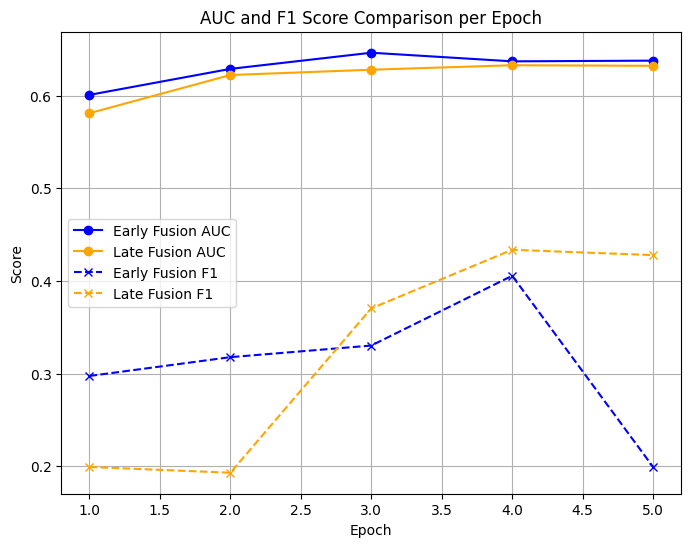

In [11]:
# ========== EARLY FUSION ==========
print("🔵 Training Early Fusion Model")

text_model_E = TextModelFeature().to(CFG.device)
image_model_E = ImageModel().to(CFG.device)
model_early = EarlyFusion(text_model_E, image_model_E).to(CFG.device)

for p in model_early.parameters():
    p.requires_grad = True





# EARLY FUSION OPTIMIZER
optimizer_early = torch.optim.AdamW([
    {'params': model_early.text_model.parameters(), 'lr': CFG.lr_text},
    {'params': model_early.image_model.parameters(), 'lr': CFG.lr_image},
    {'params': model_early.classifier.parameters(),  'lr': 1e-3},
], weight_decay=1e-4)

best_auc_early = 0
early_auc_log = []
early_f1_log = []

for epoch in range(1, CFG.epochs + 1):
    train_loss, train_auc = train_epoch(model_early, train_loader, optimizer_early, CFG.device, epoch)
    val_loss, val_auc, val_f1 = eval_epoch(model_early, val_loader, CFG.device, epoch)
    early_auc_log.append(val_auc)
    early_f1_log.append(val_f1)
    print(f"🟦 EarlyFusion | Epoch {epoch} – Train AUC: {train_auc:.4f}, Val AUC: {val_auc:.4f}, F1: {val_f1:.4f}")

    if val_auc > best_auc_early:
        best_auc_early = val_auc
        torch.save(model_early.state_dict(), "best_model_early.pth")






# ========== LATE FUSION ==========
print("\n🟠 Training Late Fusion Model")

text_model_L = TextModelLogit().to(CFG.device)
image_model_L = ImageModel().to(CFG.device)
model_late = LateFusion(text_model_L, image_model_L).to(CFG.device)

for p in model_late.parameters():
    p.requires_grad = True

# LATE FUSION OPTIMIZER
optimizer_late = torch.optim.AdamW([
    {'params': model_late.text_model.parameters(), 'lr': CFG.lr_text},
    {'params': model_late.image_model.parameters(), 'lr': CFG.lr_image},
    {'params': model_late.fc.parameters(),          'lr': 1e-3},
], weight_decay=1e-4)

best_auc_late = 0
late_auc_log = []
late_f1_log = []

for epoch in range(1, CFG.epochs + 1):
    train_loss, train_auc = train_epoch(model_late, train_loader, optimizer_late, CFG.device, epoch)
    val_loss, val_auc, val_f1 = eval_epoch(model_late, val_loader, CFG.device, epoch)
    late_auc_log.append(val_auc)
    late_f1_log.append(val_f1)
    print(f"🟧 LateFusion  | Epoch {epoch} – Train AUC: {train_auc:.4f}, Val AUC: {val_auc:.4f}, F1: {val_f1:.4f}")

    if val_auc > best_auc_late:
        best_auc_late = val_auc
        torch.save(model_late.state_dict(), "best_model_late.pth")






# ========== COMPARISON ==========
print("\n✅ Final Comparison")
print(f"Best Early Fusion Val AUC: {best_auc_early:.4f}")
print(f"Best Late  Fusion Val AUC: {best_auc_late:.4f}")

# ========== AUC & F1 Score Visualization ==========
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(range(1, CFG.epochs+1), early_auc_log, label='Early Fusion AUC', marker='o', color='blue')
plt.plot(range(1, CFG.epochs+1), late_auc_log, label='Late Fusion AUC', marker='o', color='orange')
plt.plot(range(1, CFG.epochs+1), early_f1_log, label='Early Fusion F1', linestyle='--', marker='x', color='blue')
plt.plot(range(1, CFG.epochs+1), late_f1_log, label='Late Fusion F1', linestyle='--', marker='x', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("AUC and F1 Score Comparison per Epoch")
plt.legend()
plt.grid()
plt.savefig("auc_f1_comparison.png", dpi=300)
plt.show()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


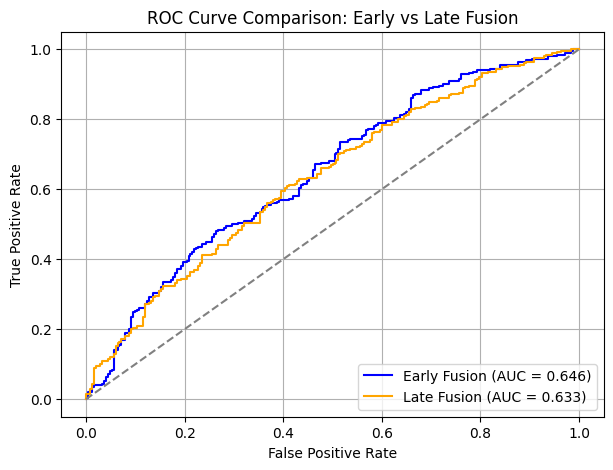

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Function to compute ROC and AUC
def get_roc_data(model, loader):
    model.eval()
    y_true, y_scores = [], []
    with torch.no_grad():
        for b in loader:
            imgs = b['image'].to(CFG.device)
            ids  = b['input_ids'].to(CFG.device)
            mask = b['attention_mask'].to(CFG.device)

            logits = model(ids, mask, imgs).cpu()
            probs = torch.sigmoid(logits).numpy()

            y_scores.extend(probs)
            y_true.extend(b['label'].cpu().numpy())

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    return fpr, tpr, auc(fpr, tpr)

# ====== Load Early Fusion Model ======
text_model_E = TextModelFeature().to(CFG.device)
image_model_E = ImageModel().to(CFG.device)
model_early = EarlyFusion(text_model_E, image_model_E).to(CFG.device)
model_early.load_state_dict(torch.load("best_model_early.pth", weights_only=True))

# ====== Load Late Fusion Model ======
text_model_L = TextModelLogit().to(CFG.device)
image_model_L = ImageModel().to(CFG.device)
model_late = LateFusion(text_model_L, image_model_L).to(CFG.device)
model_late.load_state_dict(torch.load("best_model_late.pth", weights_only=True))

# ====== Compute ROC for both ======
fpr_e, tpr_e, auc_e = get_roc_data(model_early, val_loader)
fpr_l, tpr_l, auc_l = get_roc_data(model_late, val_loader)

# ====== Plot ROC curves ======
plt.figure(figsize=(7,5))
plt.plot(fpr_e, tpr_e, label=f"Early Fusion (AUC = {auc_e:.3f})", color='blue')
plt.plot(fpr_l, tpr_l, label=f"Late Fusion (AUC = {auc_l:.3f})", color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: Early vs Late Fusion")
plt.legend(loc='lower right')
plt.grid()
plt.savefig("roc_comparison.png", dpi=300)
plt.show()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


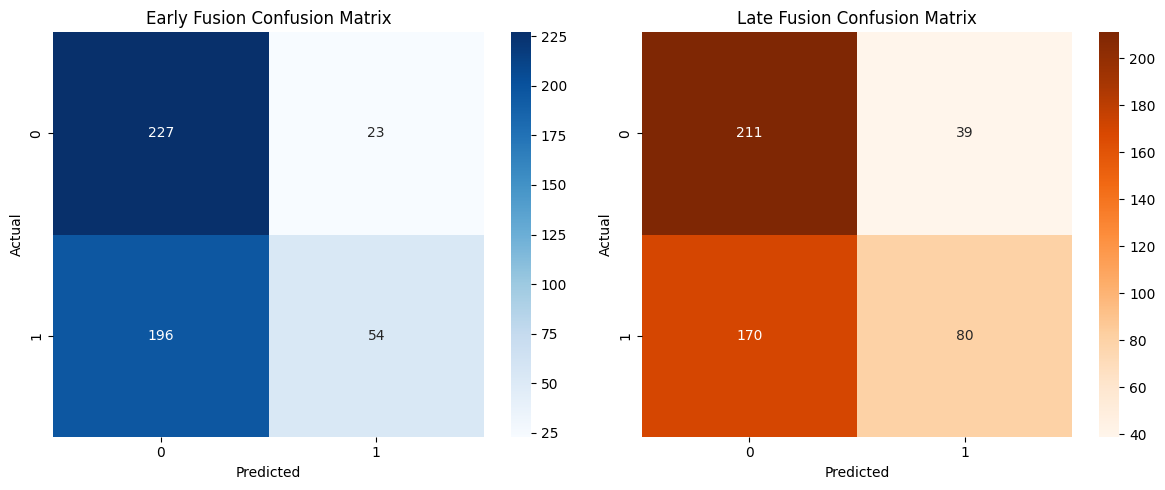

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np

def get_predictions(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for b in loader:
            imgs = b['image'].to(CFG.device)
            ids  = b['input_ids'].to(CFG.device)
            mask = b['attention_mask'].to(CFG.device)

            logits = model(ids, mask, imgs).cpu()
            probs = torch.sigmoid(logits).numpy()
            preds = (probs > 0.5).astype(int)

            y_pred.extend(preds)
            y_true.extend(b['label'].cpu().numpy())
    return np.array(y_true), np.array(y_pred)

# Load both models
text_model_E = TextModelFeature().to(CFG.device)
image_model_E = ImageModel().to(CFG.device)
model_early = EarlyFusion(text_model_E, image_model_E).to(CFG.device)
model_early.load_state_dict(torch.load("best_model_early.pth", weights_only=True))

text_model_L = TextModelLogit().to(CFG.device)
image_model_L = ImageModel().to(CFG.device)
model_late = LateFusion(text_model_L, image_model_L).to(CFG.device)
model_late.load_state_dict(torch.load("best_model_late.pth", weights_only=True))

# Get predictions
y_true_e, y_pred_e = get_predictions(model_early, val_loader)
y_true_l, y_pred_l = get_predictions(model_late, val_loader)

# Plot side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_e = confusion_matrix(y_true_e, y_pred_e)
sns.heatmap(cm_e, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Early Fusion Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

cm_l = confusion_matrix(y_true_l, y_pred_l)
sns.heatmap(cm_l, annot=True, fmt='d', cmap='Oranges', ax=axes[1])
axes[1].set_title("Late Fusion Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.savefig("confusion_matrix_comparison.png", dpi=300)
plt.show()


In [14]:
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
import numpy as np
import torch

# Choose which model to evaluate (early or late)
model = model_early  # or model_late

# Load best weights
model.load_state_dict(torch.load("best_model_early.pth", weights_only=True))
model.eval()

# Collect predictions and true labels
y_true, y_scores = [], []

with torch.no_grad():
    for b in val_loader:
        imgs = b['image'].to(CFG.device)
        ids  = b['input_ids'].to(CFG.device)
        mask = b['attention_mask'].to(CFG.device)
        labels = b['label'].cpu().numpy()

        logits = model(ids, mask, imgs).cpu().numpy()
        probs = torch.sigmoid(torch.tensor(logits)).numpy()

        y_scores.extend(probs)
        y_true.extend(labels)

# ✅ Find best threshold for F1 score
best_f1 = 0
best_thresh = 0.5

for t in np.arange(0.3, 0.7, 0.01):
    preds = [1 if p > t else 0 for p in y_scores]
    f1 = f1_score(y_true, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"✅ Best F1 = {best_f1:.4f} at threshold = {best_thresh:.2f}")


✅ Best F1 = 0.5271 at threshold = 0.30
